In [31]:

import pandas as pd
import plotly.graph_objects as go
import numpy as np
import gseapy as gp
import pickle
from pathlib import Path
import gseapy as gp
from gseapy import barplot, dotplot
import matplotlib.pyplot as plt



# load merged dataframe
df = pd.read_csv("/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/results/merged_dataframe.tsv", sep="\t")
df.head()

,node_id,module_merged,node_name
0,63,1,BCKDK
1,169,1,DNAJC1
2,199,1,TMEM246
3,222,1,PLP2
4,449,1,TOMM7


In [32]:
gp.__version__

'1.1.11'

In [33]:
# load significant enriched modules
modules_sig_enriched = pd.read_csv(
    "/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/results/sig_enriched_modules_stats.csv",
    index_col=0  # Erste Spalte als Index verwenden
)


modules_of_interest = modules_sig_enriched["module_merged"].tolist()



In [34]:
# get all genes per module of interest
genes_per_module = {}
for module in modules_of_interest:
    genes = df[df["module_merged"] == module]["node_name"].to_list()
    genes = pd.Series(genes).unique().tolist()
    genes_per_module[f"Module{module}"] = genes
    print(f"Module {module}: {len(genes)} genes")

genes_per_module




Module 11: 246 genes


{'Module11': ['SLC5A7',
  'EGR2',
  'HSPB1',
  'MPZ',
  'KBTBD13',
  'AARS',
  'NEFL',
  'YARS',
  'RAX2',
  'LRSAM1',
  'GARS',
  'ACTA1',
  'LIAT1',
  'PLEKHG5',
  'COL6A3',
  'SBF2',
  'TPM3',
  'SUMO4',
  'PGGT1B',
  'TSKS',
  'FGD4',
  'VCL',
  'TMPO',
  'TPM2',
  'CIART',
  'HSPB7',
  'HSPB8',
  'DYSF',
  'BRMS1L',
  'ACTN2',
  'RPP14',
  'DNM2',
  'DNAJB6',
  'DES',
  'DSG2',
  'NEB',
  'CALR3',
  'TPM1',
  'SGCB',
  'BIN1',
  'ZNF697',
  'GDAP1',
  'TCAP',
  'PSEN2',
  'HLA-DMB',
  'MICAL2',
  'MFN2',
  'SELENON',
  'ITGA7',
  'NEXN',
  'PMP22',
  'FHL1',
  'CFAP410',
  'CAV3',
  'MAP7D3',
  'GNE',
  'STARD8',
  'JPH1',
  'CFL2',
  'HSPB2',
  'MYOM2',
  'MYBPC2',
  'CMYA5',
  'C11orf63',
  'BICD2',
  'TDP1',
  'TRIM2',
  'TRIM32',
  'CHRNA1',
  'TTN',
  'FHL2',
  'SGCA',
  'ARHGEF10',
  'LAMA2',
  'MYH14',
  'REEP1',
  'MBLAC1',
  'MYOZ2',
  'MYH6',
  'SIGMAR1',
  'CHRNA2',
  'HSPB3',
  'IGHMBP2',
  'MYBPC3',
  'DNAJB2',
  'GALNT8',
  'DOLK',
  'FLNC',
  'CSRP3',
  'HINT1',
  '

In [35]:
# load GSEA libraries
libraries = {}

folder_path = Path("/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/Data/raw/GSEA_libraries")
files = folder_path.glob("*.pkl")

for file in files:
    library_name = file.stem
    with open(file, 'rb') as f:
        libraries[library_name] = pickle.load(f)
    print(f"Loaded {library_name}")

print(f"\nTotal libraries loaded: {len(libraries)}")
print(f"Library names: {list(libraries.keys())}")


Loaded Reactome_Pathways_2024_Human
Loaded GO_Cellular_Component_2023_Human
Loaded WikiPathways_2024_Human_Human
Loaded GO_Biological_Process_2023_Human
Loaded GO_Molecular_Function_2023_Human

Total libraries loaded: 5
Library names: ['Reactome_Pathways_2024_Human', 'GO_Cellular_Component_2023_Human', 'WikiPathways_2024_Human_Human', 'GO_Biological_Process_2023_Human', 'GO_Molecular_Function_2023_Human']


In [36]:
for module_name, gene_list in genes_per_module.items():
    print(gene_list[:5])  # print first 5 genes of each module

['SLC5A7', 'EGR2', 'HSPB1', 'MPZ', 'KBTBD13']


In [ ]:
# set the background as all genes in the merged dataframe (= all genes in the multiplex network)
background_genes = pd.Series(df["node_name"]).unique().tolist()
len(background_genes)


15261

In [38]:
# Create output directory
out_root = Path("/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/Data/processed/enrichr_modules")
out_root.mkdir(exist_ok=True)

all_results = []
# perform enrich R for each module and each library
for module_name, gene_list in genes_per_module.items():
    module_dir = out_root / module_name
    module_dir.mkdir(exist_ok=True)
    
    for lib_name, gene_set in libraries.items():
        print(f"Processing {module_name} with {lib_name}...")
        
        try:
            enr = gp.enrichr(
                gene_list=gene_list,
                gene_sets=gene_set,         # nur diese Library
                outdir=str(module_dir / lib_name),
                cutoff=0.5,
                background= background_genes
            )
        except ValueError as e:
            # if there is "No enrich terms ..."
            msg = str(e)
            if "No enrich terms" in msg:
                print(f"  No significant terms (cutoff=0.5) – skipping.")
                continue
            else:
                # if a different error occurs, re-raise it
                raise
        
        # If no error: check results
        if enr.results is None or enr.results.empty or len(enr.results) == 0:
            print(f"  No significant terms in enr.results – skipping.")
            continue
        print(f"  Results for {module_name} / {lib_name} have been generated.")
        df = enr.results.copy()
        df["module"] = module_name
        df["library"] = lib_name
        
        
        all_results.append(df)

# Combine all into one file
all_df = pd.concat(all_results, ignore_index=True)
all_df.to_csv(out_root / "ALL_MODULES_ALL_LIBRARIES.csv", index=False)
        
       
        

Processing Module11 with Reactome_Pathways_2024_Human...
  Results for Module11 / Reactome_Pathways_2024_Human have been generated.
Processing Module11 with GO_Cellular_Component_2023_Human...
  Results for Module11 / GO_Cellular_Component_2023_Human have been generated.
Processing Module11 with WikiPathways_2024_Human_Human...
  Results for Module11 / WikiPathways_2024_Human_Human have been generated.
Processing Module11 with GO_Biological_Process_2023_Human...
  Results for Module11 / GO_Biological_Process_2023_Human have been generated.
Processing Module11 with GO_Molecular_Function_2023_Human...
  Results for Module11 / GO_Molecular_Function_2023_Human have been generated.


In [39]:
all_df.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,module,library
0,gs_ind_0,Acetylcholine Binding and Downstream Events,10/14,9.335549e-16,7.412426e-14,148.105004,5125.548635,CHRNA2;CHRNA6;CHRND;CHRNB4;CHRNB3;CHRNE;CHRNA5...,Module11,Reactome_Pathways_2024_Human
1,gs_ind_0,Acetylcholine Neurotransmitter Release Cycle,3/17,2.380342e-03,4.973662e-02,14.870849,89.827529,SLC18A3;SLC5A7;CHAT,Module11,Reactome_Pathways_2024_Human
2,gs_ind_0,Activated NOTCH1 Transmits Signal to the Nucleus,1/31,3.960575e-01,8.569553e-01,3.002003,2.780443,PSEN2,Module11,Reactome_Pathways_2024_Human
3,gs_ind_0,Activation of Anterior HOX Genes in Hindbrain ...,2/69,3.058600e-01,8.314329e-01,2.264410,2.682483,EGR2;HOXC4,Module11,Reactome_Pathways_2024_Human
4,gs_ind_0,Activation of HOX Genes During Differentiation,2/69,3.058600e-01,8.314329e-01,2.264410,2.682483,EGR2;HOXC4,Module11,Reactome_Pathways_2024_Human


In [40]:
len(all_df)


2277

In [41]:
#show top 5 terms per module and library 
sig = all_df[all_df["Adjusted P-value"] < 0.05]
print(len(sig))
top_per_mod_lib = (
    sig
    .sort_values("Adjusted P-value")      # sort by significance
    .groupby(["module", "library"])      # group by module + library
    .head(5)                              # Top 5 per group
)


print(len(top_per_mod_lib))




173
25


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/gseapy/plot.py:756: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda _x: _x.sort_values(by=self.colname).tail(self.n_terms))


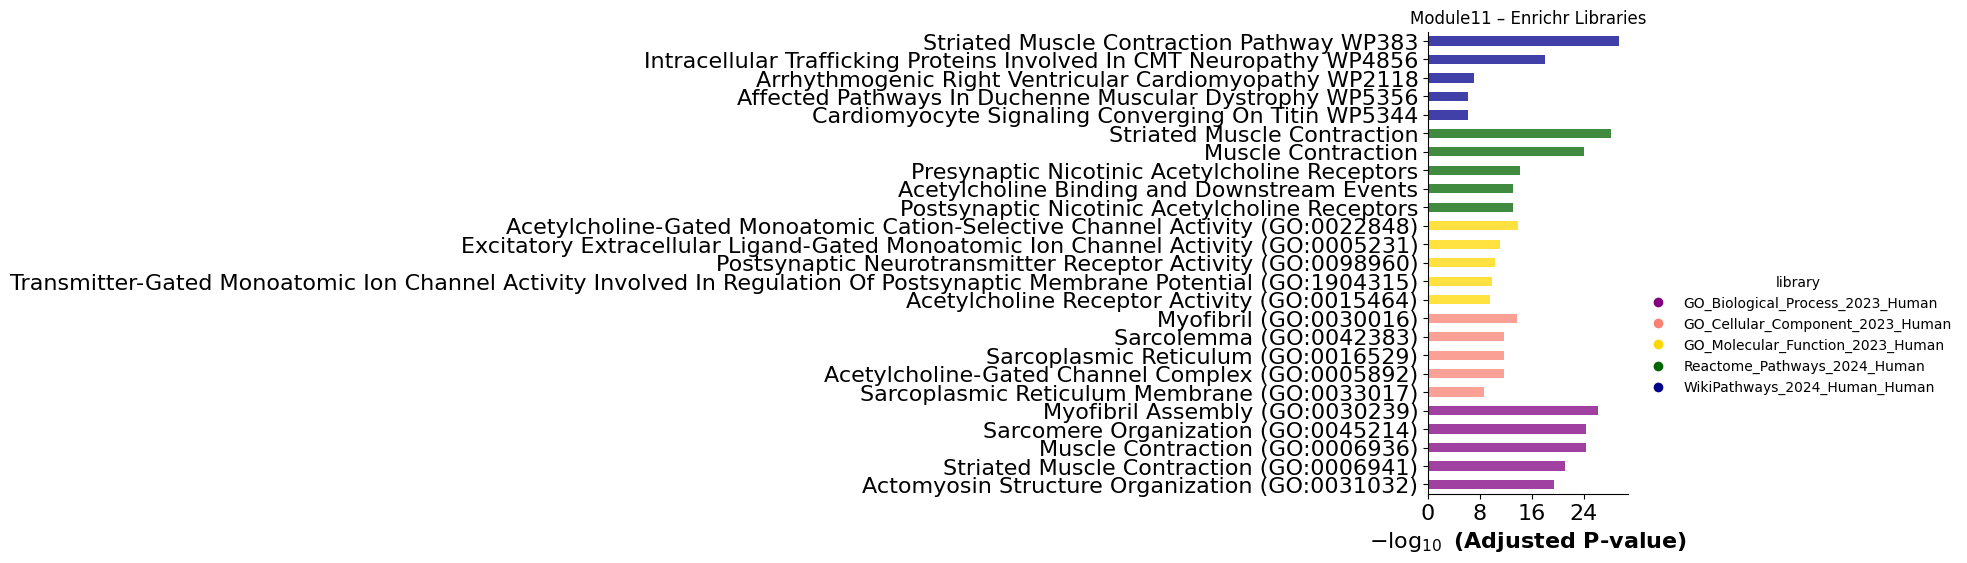

In [42]:
# define consistent color mapping for libraries
library_colors = {
   
    'GO_Cellular_Component_2023_Human': 'salmon',
    'WikiPathways_2024_Human_Human': 'darkblue',
    'Reactome_Pathways_2024_Human': 'darkgreen',
    'GO_Biological_Process_2023_Human': 'purple',
    'GO_Molecular_Function_2023_Human': 'gold'
}

# plot top 5 terms per module and library
for mod in sorted(all_df['module'].unique()):
    # subset the data for one module
    res = all_df[all_df['module'] == mod].copy()
    
    # only keep top 5 terms per library
    res = (
        res
        .sort_values('Adjusted P-value', ascending=True)
        .groupby('library', group_keys=False)
        .head(5)  # Top 5 Terms per library
    )
    
    # barplot: column = what is plotted; group = category for color grouping
    ax = gp.barplot(
        res,
        column="Adjusted P-value",
        group='library',            
        size=8,             
        figsize=(4, 6),
        color=library_colors        # Mapping: Library → color
    )
    
    ax.set_title(f"{mod} – Enrichr Libraries")
    # Adjust left margin to make room for labels
    plt.subplots_adjust(left=0.4)
    ax.figure.savefig(
        f"/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/results/{mod}_Enrichr_Libraries.png",
        bbox_inches='tight',
        dpi=300
    )
    plt.show()
    

In [43]:
# load disease genes
with open("/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/Data/raw/disease_genes.txt", "r") as f:
    disease_genes = f.read().splitlines()

In [44]:
# define background as all genes in the significant module
# define gene_list as intersection of disease genes and genes in the significant module
module= modules_of_interest[0]
background_genes = genes_per_module[f"Module{module}"]
gene_list = list(set(background_genes) & set(disease_genes))
gene_list

['GFPT1',
 'SYT2',
 'CHRND',
 'SLC5A7',
 'COL13A1',
 'COLQ',
 'SLC18A3',
 'CHRNB1',
 'CHRNE',
 'CHAT',
 'CHRNA1',
 'DES',
 'SCN4A']

In [45]:
# enriched terms in disease genes in significant module to background (all genes in significant module)
all_res_mod = []
for lib_name, gene_set in libraries.items():
        print(f"Processing {module_name} with {lib_name}...")
        enr = gp.enrichr(
                gene_list=gene_list,
                gene_sets=gene_set,         
                outdir=str(module_dir / lib_name),
                cutoff=0.5,
                background= background_genes)
        print(f"  Results for {module_name} / {lib_name} have been generated.")
        df = enr.results.copy()
        df["library"] = lib_name
        
        
        all_res_mod.append(df)
all_df_12 = pd.concat(all_res_mod, ignore_index=True) 


Processing Module11 with Reactome_Pathways_2024_Human...
  Results for Module11 / Reactome_Pathways_2024_Human have been generated.
Processing Module11 with GO_Cellular_Component_2023_Human...
  Results for Module11 / GO_Cellular_Component_2023_Human have been generated.
Processing Module11 with WikiPathways_2024_Human_Human...
  Results for Module11 / WikiPathways_2024_Human_Human have been generated.
Processing Module11 with GO_Biological_Process_2023_Human...
  Results for Module11 / GO_Biological_Process_2023_Human have been generated.
Processing Module11 with GO_Molecular_Function_2023_Human...
  Results for Module11 / GO_Molecular_Function_2023_Human have been generated.


In [48]:
#show top 5 terms per library 
sig = all_df_12[all_df_12["Adjusted P-value"] < 0.05]
print(len(sig))
top_per_mod_lib = (
    sig
    .sort_values("Adjusted P-value")      # sort by significance
    .groupby(["library"])      # group by  Library
    .head(5)                              # top 5 per group
)
top_per_mod_lib
len(top_per_mod_lib)


32


21

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/gseapy/plot.py:756: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda _x: _x.sort_values(by=self.colname).tail(self.n_terms))


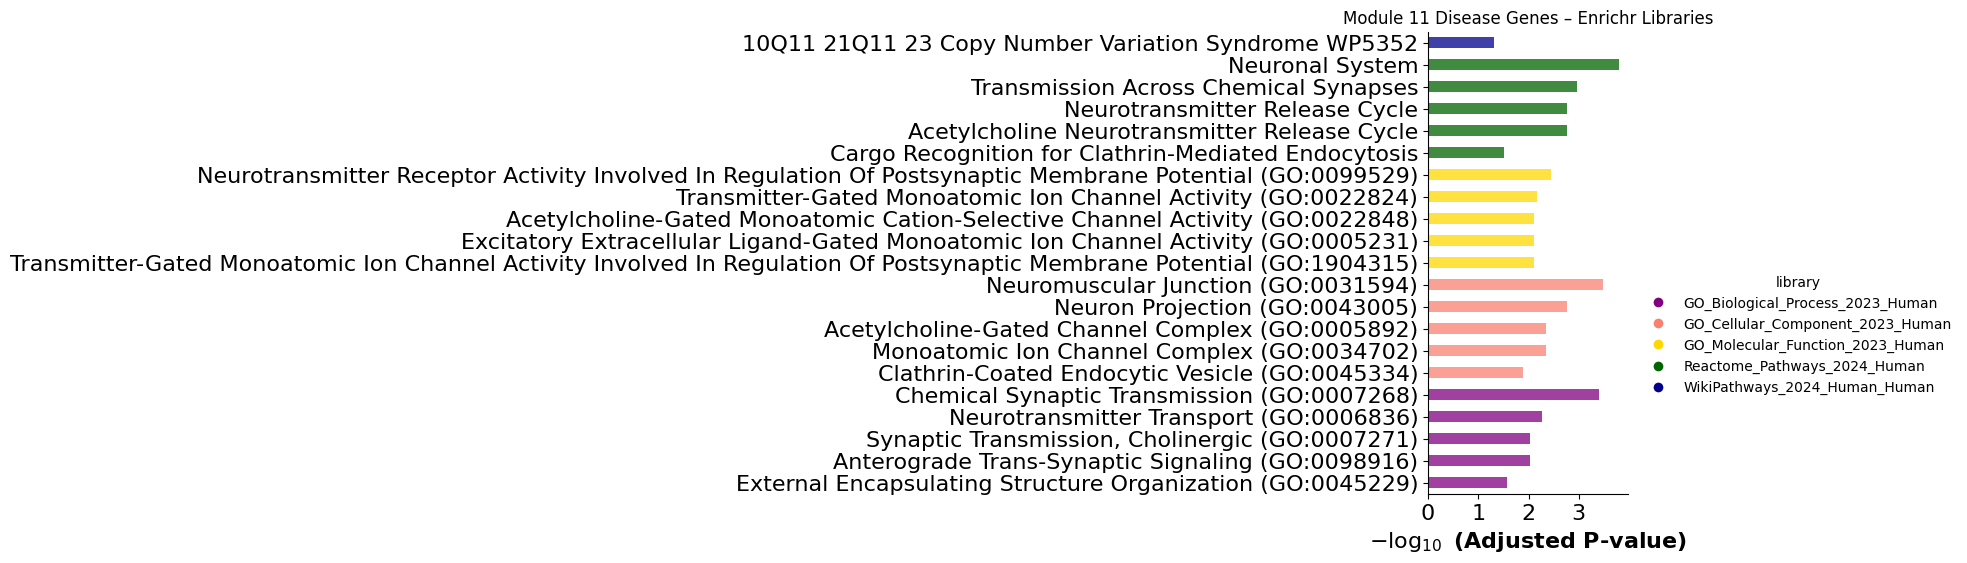

In [47]:
# define consistent color mapping for libraries
library_colors = {
    'GO_Cellular_Component_2023_Human': 'salmon',
    'WikiPathways_2024_Human_Human': 'darkblue',
    'Reactome_Pathways_2024_Human': 'darkgreen',
    'GO_Biological_Process_2023_Human': 'purple',
    'GO_Molecular_Function_2023_Human': 'gold'
}

# only keep top 5 terms per library
res = (
    all_df_12
    .sort_values('Adjusted P-value', ascending=True)
    .groupby('library', group_keys=False)
    .head(5)  # Top 5 Terms per library
)

# barplot: column = what is plotted; group = category for color grouping
ax = gp.barplot(
    res,
    column="Adjusted P-value",
    group='library',            
    size=8,             
    figsize=(4, 6),
    color=library_colors        # Mapping: Library → color
)

ax.set_title(f"Module {module} Disease Genes – Enrichr Libraries")
# Adjust left margin to make room for labels
plt.subplots_adjust(left=0.4)
ax.figure.savefig(
    f"/Users/paulinestaiber/Documents/Network/Multiplex-Network-Community-detection/results/Module{module}_DiseaseGenes_Enrichr_Libraries.png",
    bbox_inches='tight',
    dpi=300
)
plt.show()
